# Capstone Project: Airbnb Prediciting Prices 
____

In [638]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn import metrics
from sklearn.metrics import r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Dropout, Input

from sklearn.model_selection import cross_val_predict, cross_val_score

import pickle

In [639]:
# Reading dataset
listing = pd.read_csv('../data/listings_model.csv')

In [640]:
listing.columns

Index(['host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type',
       'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'review_scores_rating',
       'instant_bookable', 'bathrooms_type', 'bathrooms_nbr',
       'neigh_price_sqft', 'description_count', 'description_words',
       'amenities_count'],
      dtype='object')

# 3. Pre-Processing Data 
____

Check Distribution Data 
Check Outliers
Visualizations:
    - Barcharts by accomodation type
    - Scatter plot price acomodation (type accomodation legend) (?)
    - Map location lat/log (Folium) (?)
    - Time/price (?)     


In [641]:
listing.shape

(22183, 24)

In [642]:
listing['room_type'].value_counts()

Entire home/apt    11942
Private room        9843
Shared room          336
Hotel room            62
Name: room_type, dtype: int64

In [643]:
listing[listing['room_type']=='Private room'].loc[0]

host_is_superhost                                                               0
host_verifications                                             ['email', 'phone']
host_has_profile_pic                                                            1
host_identity_verified                                                          1
neighbourhood_cleansed                                                 kensington
neighbourhood_group_cleansed                                             Brooklyn
latitude                                                                 40.64529
longitude                                                               -73.97238
room_type                                                            Private room
accommodates                                                                    2
bedrooms                                                                      1.0
beds                                                                          1.0
price           

In [644]:
df  = listing.copy()
# Running model only on Private room
#df = listing[listing['room_type']=='Private room']

In [645]:
df.columns

Index(['host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type',
       'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'review_scores_rating',
       'instant_bookable', 'bathrooms_type', 'bathrooms_nbr',
       'neigh_price_sqft', 'description_count', 'description_words',
       'amenities_count'],
      dtype='object')

In [646]:
df.drop( columns=['host_verifications', 'neighbourhood_group_cleansed',
                'latitude', 'longitude', 'description_words', 'description_count','number_of_reviews'], 
         inplace=True)

In [647]:
df.columns

Index(['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'review_scores_rating', 'instant_bookable', 'bathrooms_type',
       'bathrooms_nbr', 'neigh_price_sqft', 'amenities_count'],
      dtype='object')

In [648]:
df.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,review_scores_rating,instant_bookable,bathrooms_type,bathrooms_nbr,neigh_price_sqft,amenities_count
0,0,1,1,kensington,Private room,2,1.0,1.0,299.0,30,730,4.89,0,shared,1.0,2.77,557
1,1,1,1,bedford-stuyvesant,Private room,2,1.0,1.0,60.0,30,730,4.52,0,private,0.0,2.83,77
2,0,1,1,sunset park,Entire home/apt,4,2.0,2.0,275.0,21,1125,5.00,0,private,1.5,2.31,386
3,1,1,1,greenpoint,Hotel room,2,1.0,1.0,308.0,2,365,4.90,0,private,1.0,3.83,432
4,0,1,1,east village,Private room,2,1.0,2.0,55.0,2,60,4.34,0,shared,1.5,5.71,266


In [649]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22183 entries, 0 to 22182
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_is_superhost       22183 non-null  int64  
 1   host_has_profile_pic    22183 non-null  int64  
 2   host_identity_verified  22183 non-null  int64  
 3   neighbourhood_cleansed  22183 non-null  object 
 4   room_type               22183 non-null  object 
 5   accommodates            22183 non-null  int64  
 6   bedrooms                22183 non-null  float64
 7   beds                    22183 non-null  float64
 8   price                   22183 non-null  float64
 9   minimum_nights          22183 non-null  int64  
 10  maximum_nights          22183 non-null  int64  
 11  review_scores_rating    22183 non-null  float64
 12  instant_bookable        22183 non-null  int64  
 13  bathrooms_type          22183 non-null  object 
 14  bathrooms_nbr           22183 non-null

In [650]:
#df.to_csv('../data/listing_preprocess.csv', index=False)

## 3.2. Creating X and y 

In [651]:
X = df.drop(columns='price')
y = np.log(df['price'])
print(X.shape)
print(y.shape)

(22183, 16)
(22183,)


In [652]:
X_train, X_test, y_train, y_test = train_test_split(
        X,  
        y,
        test_size = 0.3,     
        random_state = 42
 )

In [653]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15528, 16), (6655, 16), (15528,), (6655,))

## 3.3. Transformers

In [654]:
df.columns

Index(['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'review_scores_rating', 'instant_bookable', 'bathrooms_type',
       'bathrooms_nbr', 'neigh_price_sqft', 'amenities_count'],
      dtype='object')

In [655]:
col_ss = ['accommodates', 'bedrooms','beds', 'minimum_nights', 'maximum_nights',
          'review_scores_rating', 'bathrooms_nbr', 'neigh_price_sqft', 'amenities_count']
col_ohe = ['neighbourhood_cleansed', 'bathrooms_type', 'room_type'] 

In [656]:
ctx = ColumnTransformer(
    transformers =[
        ('ohe', OneHotEncoder(drop = 'if_binary', sparse = False, handle_unknown = 'ignore'), col_ohe),
        ('ss', StandardScaler(), col_ss)
    ]
)

In [657]:
X_train.columns

Index(['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'minimum_nights', 'maximum_nights', 'review_scores_rating',
       'instant_bookable', 'bathrooms_type', 'bathrooms_nbr',
       'neigh_price_sqft', 'amenities_count'],
      dtype='object')

In [658]:
X_train_sc = ctx.fit_transform(X_train)
X_test_sc = ctx.transform(X_test)
X_train_sc.shape, X_test_sc.shape

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


((15528, 167), (6655, 167))

# 4. Machine Learning Models
____

## 4.1. Baseline Model

In [659]:
#Setting a Baseline and getting its Score
baseline_model = [y_train.mean()] * len(y_test)
r2_score(y_test, baseline_model)

-0.00019758509399592228

### Fitting Regression Model
___

In [660]:
#Fitting Model
lr = LinearRegression()
lr.fit(X_train_sc, y_train)

LinearRegression()

In [661]:
#Cross Vaditadion Score
cross_val_score(lr, X_train_sc, y_train, cv=5).mean()
# -3.3924557963554062e+25

-1.6279957810500911e+19

In [662]:
#Comparing scores
print(f'Train set: {lr.score(X_train_sc, y_train)}')
print(f'Test set: {lr.score(X_test_sc, y_test)}')
print(f'Diference (train/test): {lr.score(X_train_sc, y_train)-lr.score(X_test_sc, y_test)}')

Train set: 0.6493298597499471
Test set: -4.4354846159887034e+17
Diference (train/test): 4.4354846159887034e+17


In [663]:
# Calcuate residual
lr_y_preds = np.exp(lr.predict(X_train_sc))
residuals = y_train - lr_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, lr_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, lr_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, lr_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, lr_y_preds)}')
#MAE: 129.81014920371308
#MSE: 21210.975157781893
#RMSE: 145.63988175558882
#R2: -55534.009329901186

MAE: 130.0644276040149
MSE: 21461.767848811694
RMSE: 146.49835442356238
R2: -56023.485027103736


In [664]:
lr.coef_

array([ 1.27418095e+07,  2.37688123e+10, -8.47156907e+09,  7.64862160e+09,
       -7.54976250e+10, -1.96693073e+09,  3.08390713e+10, -8.75437944e+09,
       -8.47156907e+09, -1.89355525e+10,  1.27392081e+10, -7.38007629e+10,
        4.53770761e+09, -5.36065508e+09,  2.27522471e+09, -8.11538323e+10,
        1.55673118e+10, -7.62313798e+09,  1.18907770e+10, -3.22276395e+10,
        6.51738015e+09,  8.21424233e+09, -1.41392440e+11, -1.19898852e+11,
       -6.98414178e+10,  1.83954154e+10, -7.97397805e+10,  8.21424233e+09,
        4.83733138e+10, -1.78043110e+10, -5.34384167e+10,  3.70608993e+10,
        1.44360703e+10, -1.58246385e+10,  8.21424233e+09, -1.15824831e+10,
        3.22531232e+10, -7.29523318e+10, -1.08586437e+11,  2.00922776e+10,
        2.84084544e+09, -3.47729328e+10, -7.62313798e+09, -8.99209535e+10,
        1.30220185e+10,  1.10423460e+10,  5.38613870e+09,  3.05562610e+10,
        6.51738015e+09, -8.85069017e+10, -4.79503436e+09, -1.29231594e+11,
        1.21735874e+10,  

In [665]:
# Creating a list of coeficients
list_coef = list(zip(lr.coef_, ctx.get_feature_names_out()))

In [666]:
X_train_df = pd.DataFrame(X_train_sc, columns = ctx.get_feature_names_out())

In [667]:
# Turn it into a data frame
df_coef = pd.DataFrame(lr.coef_, index = ctx.get_feature_names_out(), columns = ['Coefficient'])

In [668]:
df_coef.sort_values(by='Coefficient', ascending=False)

,Coefficient
ohe__room_type_Hotel room,1.797874e+12
ohe__room_type_Entire home/apt,1.797874e+12
ohe__room_type_Private room,1.797874e+12
ohe__room_type_Shared room,1.797874e+12
ohe__neighbourhood_cleansed_highbridge,5.148423e+10
...,...
ohe__neighbourhood_cleansed_flatiron district,-1.292316e+11
ohe__neighbourhood_cleansed_noho,-1.371503e+11
ohe__neighbourhood_cleansed_central park,-1.413924e+11
ohe__neighbourhood_cleansed_tribeca,-1.445034e+11


### Residuals
___

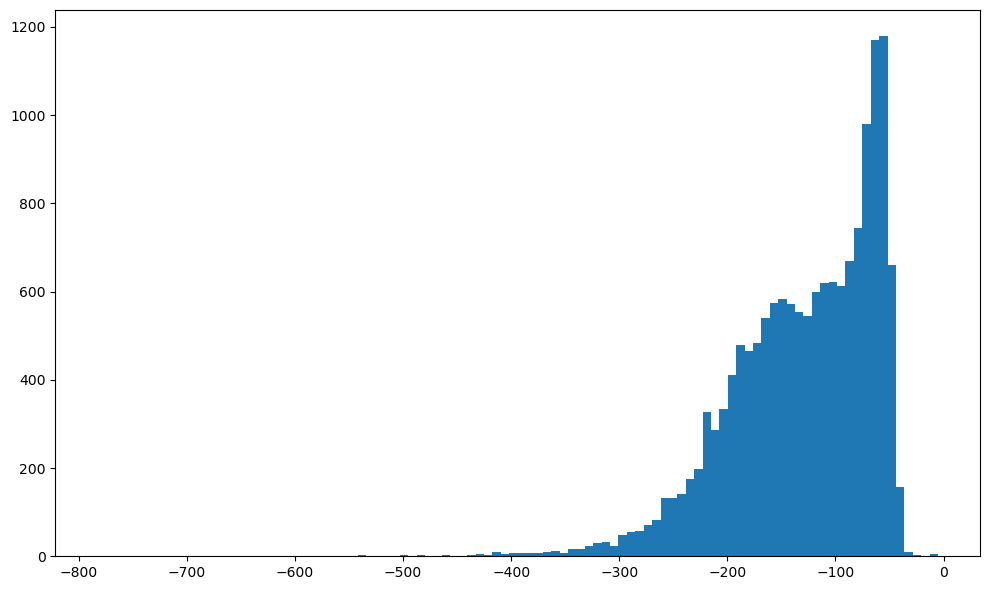

In [669]:
# Normality assumption 
plt.figure(figsize = (10, 6))
plt.hist(residuals, bins = 100);
plt.tight_layout()

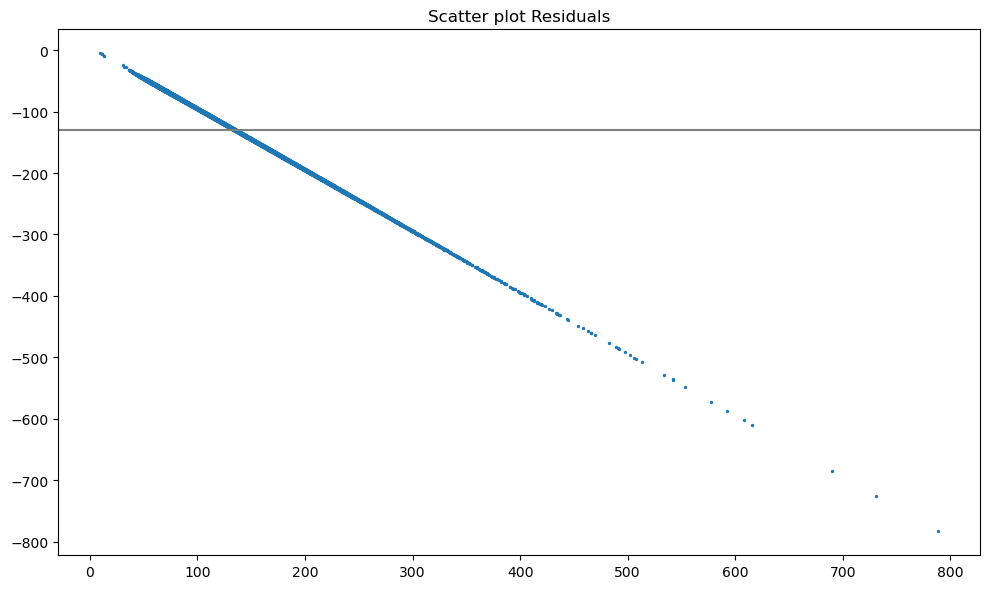

In [670]:
# Normality assumption 
plt.figure(figsize = (10,6))
plt.title("Scatter plot Residuals")
#Ploting Residuals - Scatter Plotf SLR Model 
plt.scatter(lr_y_preds, residuals,s=2);
plt.axhline(residuals.mean(), color='grey');
plt.tight_layout()

## 4.2. Lasso Regularization

In [671]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas)

# Fit model using best ridge alpha!
lasso_cv.fit(X_train_sc, y_train)

LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]))

In [672]:
# Here is the optimal value of alpha
print("Best Value of alpha: ",lasso_cv.alpha_)

# Scores on Train a
print("Lasson Train Score: ", lasso_cv.score(X_train_sc, y_train))
print("Lasso Test Score", lasso_cv.score(X_test_sc, y_test))

Best Value of alpha:  0.001
Lasson Train Score:  0.6361272959823889
Lasso Test Score 0.6272351998879183


In [673]:
# Calcuate residual
lasso_y_preds = np.exp(lasso_cv.predict(X_train_sc))
residuals = y_train - lasso_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, lasso_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, lasso_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, lasso_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, lasso_y_preds)}')

MAE: 129.35162016641215
MSE: 21013.713228805504
RMSE: 144.9610748746211
R2: -54853.868920607114


## 4.3. Ridge Regularization

In [674]:
# Instantiate.
ridge = Ridge(alpha = 100)

# Fit.
ridge.fit(X_train_sc, y_train)

# Evaluate model using R2.
print(f'Training Score: {ridge.score(X_train_sc, y_train)}')
print(f'Testing Score: {ridge.score(X_test_sc, y_test)}')

Training Score: 0.6401766198186942
Testing Score: 0.6295447314841209


In [675]:
# Calcuate residual
ridge_y_preds = np.exp(ridge.predict(X_train_sc))
residuals = y_train - ridge_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, ridge_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, ridge_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, ridge_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, ridge_y_preds)}')

MAE: 129.29965180080228
MSE: 20959.746324633317
RMSE: 144.77481246623432
R2: -54712.99198837802


## 4.4. KNNeighbors Regressor


In [676]:
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# define the grid search
knn_grid= GridSearchCV(KNeighborsRegressor(), param_grid=knn_params, cv=5, verbose = -1)
knn_grid.fit(X_train_sc, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'p': [1, 2]},
             verbose=-1)

In [535]:
knn_grid.best_params_

{'algorithm': 'auto', 'n_neighbors': 15, 'p': 1}

In [536]:
print(f'Training Score: {knn_grid.score(X_train_sc, y_train)}')
print(f'Testing Score: {knn_grid.score(X_test_sc, y_test)}')

# Calcuate residual
knn_grid_y_preds = np.exp(knn_grid.best_estimator_.predict(X_train_sc))
residuals = y_train - knn_grid_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, knn_grid_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, knn_grid_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, knn_grid_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, knn_grid_y_preds)}')

Training Score: 0.7198295137423087
Testing Score: 0.6619027948256624
MAE: 130.38341023920955
MSE: 21465.543509344367
RMSE: 146.51124021502366
R2: -56033.34113208402


In [537]:
knn = KNeighborsRegressor(n_neighbors=5, p=2)
knn.fit(X_train_sc, y_train)

print(f'Training Score: {knn.score(X_train_sc, y_train)}')
print(f'Testing Score: {knn.score(X_test_sc, y_test)}')

# Calcuate residual
knn_y_preds = np.exp(knn.predict(X_train_sc))
residuals = y_train - knn_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, knn_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, knn_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, knn_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, knn_y_preds)}')

Training Score: 0.766742257090349
Testing Score: 0.6338158087385041
MAE: 132.4699085239637
MSE: 22646.359589001717
RMSE: 150.4870744914716
R2: -59115.78118271523


## 4.5. CART 

In [538]:
# Instantiate model with:
# - a maximum depth of .
# - at least  samples required in order to split an internal node.
# - at least  samples in each leaf node.
# - a cost complexity of 0.01.
# - random state of 42.

dt_params = {
    'max_depth': [2, 3, 5, 7],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'ccp_alpha': [0.001, 0.01, 0.1, 1, 10]
}

dt_grid = GridSearchCV(
                    estimator = DecisionTreeRegressor(random_state=42),
                    param_grid = dt_params,
                    cv = 5,
                    verbose = 1)

# GridSearch!
dt_grid.fit(X_train_sc, y_train)

# What is our best decision tree?
print("Best Estimator: ", dt_grid.best_estimator_)

# What was the cross-validated score of the above decision tree?
print("Best Score: ", dt_grid.best_score_)

# Evaluate model.
print(f'Score on training set: {dt_grid.score(X_train_sc, y_train)}')
print(f'Score on testing set: {dt_grid.score(X_test_sc, y_test)}')


Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best Estimator:  DecisionTreeRegressor(ccp_alpha=0.001, max_depth=7, min_samples_leaf=2,
                      min_samples_split=5, random_state=42)
Best Score:  0.6145204730166037
Score on training set: 0.6231104171892097
Score on testing set: 0.6029381329430296


In [539]:
# Calcuate residual
dt_y_preds = np.exp(dt_grid.best_estimator_.predict(X_train_sc))
residuals = y_train - dt_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, dt_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, dt_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, dt_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, dt_y_preds)}')

MAE: 129.03700239303083
MSE: 20476.175754086602
RMSE: 143.09498857083221
R2: -53450.66390897693


## 4.6. Random Forest

In [540]:
# Taking 47 min to run
# Gridsearch Parameters
rf_params = {
    'n_estimators': [200, 250, 300, 400],
    'min_samples_leaf': [2, 3, 4, 5],
    'max_depth' : [None, 3, 4, 5, 6],
    # max_features = TO DO
    'n_jobs': [-1]
}
# Setting Gridsearch
rf_grid = GridSearchCV(
    estimator = RandomForestRegressor(), 
    param_grid = rf_params, 
    cv = 5
)
# Fitting Model
rf_grid.fit(X_train_sc, y_train)

# Printing Outputs
print(f'Best Score : {rf_grid.best_score_}')
print(f'Best Parameters: {rf_grid.best_params_}') 
print(f'Score on training set: {rf_grid.score(X_train_sc, y_train)}')
print(f'Score on test set: {rf_grid.score(X_test_sc, y_test)}')

Best Score : 0.6961960062052944
Best Parameters: {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 400, 'n_jobs': -1}
Score on training set: 0.8865569149957151
Score on test set: 0.6817863215376742


In [541]:
# Calcuate residual
rf_y_preds = np.exp(rf_grid.best_estimator_.predict(X_train_sc))
residuals = y_train - rf_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, rf_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, rf_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, rf_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, rf_y_preds)}')

MAE: 132.4863503584238
MSE: 22639.58032479946
RMSE: 150.46454839861602
R2: -59098.08437467641


## 4.7. Neural Network

In [542]:
def model_fn(h1_neurons = 32, h2_neurons=32, drop = 0.5):
  
  print(f'h1: {h1_neurons}, h2: {h2_neurons}, drop: {drop}')
  
  inputs = Input(shape = (X_train_sc.shape[1],))
  
  h1 = Dense(h1_neurons, activation = 'relu')(inputs)
  d1 = Dropout(drop)(h1)
  h2 = Dense(h2_neurons, activation = 'relu')(d1)
  
  out = Dense(1, activation = None)(h2)

  model = Model(inputs = inputs, outputs = out)

  model.compile(loss = 'mse',
                optimizer = 'adam', 
                metrics='mse')

  
  return model

In [543]:
# kind of like when lr = LinearRegression()
nn = KerasRegressor(build_fn = model_fn, batch_size = 256, verbose = 0)

In [ ]:
nn.

In [544]:
params = {
    'epochs': [100],
    'h1_neurons': [16, 64, 128],
    'h2_neurons': [64, 128],
    'drop':[0.1,0.25, 0.5]
}

In [545]:
# 19 min to run
nn_grid = GridSearchCV(nn, param_grid = params, cv = 3)
nn_grid.fit(X_train_sc, y_train)

h1: 16, h2: 64, drop: 0.1


2022-11-14 12:57:19.728437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 12:57:41.646287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.1


2022-11-14 12:57:42.285179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 12:58:01.840329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.1


2022-11-14 12:58:02.555249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 12:58:21.616464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.1


2022-11-14 12:58:22.327287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 12:58:41.890508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.1


2022-11-14 12:58:42.444328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 12:59:01.724460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.1


2022-11-14 12:59:03.249274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 12:59:23.853320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.1


2022-11-14 12:59:24.348909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 12:59:43.782674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.1


2022-11-14 12:59:44.277479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:00:02.472286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.1


2022-11-14 13:00:02.945563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:00:21.645398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.1


2022-11-14 13:00:22.114640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:00:41.155122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.1


2022-11-14 13:00:41.607484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:01:00.750637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.1


2022-11-14 13:01:01.356016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:01:20.843384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.1


2022-11-14 13:01:21.566309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:01:41.642640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.1


2022-11-14 13:01:42.383530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:02:01.649608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.1


2022-11-14 13:02:03.370548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:02:24.982745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.1


2022-11-14 13:02:25.477207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:02:44.623734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.1


2022-11-14 13:02:45.136599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:03:03.278467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.1


2022-11-14 13:03:03.827917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:03:21.513874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.25


2022-11-14 13:03:22.170375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:03:39.919716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.25


2022-11-14 13:03:40.376421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:03:57.977660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.25


2022-11-14 13:03:58.534104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:04:16.192811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.25


2022-11-14 13:04:16.526390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:04:33.991990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.25


2022-11-14 13:04:34.364218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:04:51.899418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.25


2022-11-14 13:04:52.379855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:05:09.704282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.25


2022-11-14 13:05:11.264184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:05:31.139093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.25


2022-11-14 13:05:31.704806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:05:50.172430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.25


2022-11-14 13:05:50.827190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:06:09.152918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.25


2022-11-14 13:06:09.764957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:06:30.638661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.25


2022-11-14 13:06:31.521618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:06:53.280147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.25


2022-11-14 13:06:53.867473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:07:13.288682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.25


2022-11-14 13:07:14.044608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:07:34.566862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.25


2022-11-14 13:07:35.322693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:07:57.802232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.25


2022-11-14 13:07:58.353904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:08:18.204793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.25


2022-11-14 13:08:19.728382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:08:39.012854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.25


2022-11-14 13:08:39.398859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:08:56.717013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.25


2022-11-14 13:08:57.048273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:09:14.748158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.5


2022-11-14 13:09:15.074232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:09:32.618808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.5


2022-11-14 13:09:32.955654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:09:50.450840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.5


2022-11-14 13:09:50.871727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:10:09.009561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.5


2022-11-14 13:10:09.554862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:10:27.184406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.5


2022-11-14 13:10:27.568555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:10:44.638648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.5


2022-11-14 13:10:44.976744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:11:02.146898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.5


2022-11-14 13:11:02.489359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:11:20.508780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.5


2022-11-14 13:11:20.909809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:11:39.015183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.5


2022-11-14 13:11:39.343481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:11:56.889006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.5


2022-11-14 13:11:57.311546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:12:14.799457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.5


2022-11-14 13:12:15.140763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:12:32.413039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.5


2022-11-14 13:12:33.050930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:12:50.501680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.5


2022-11-14 13:12:50.847107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:13:08.618521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.5


2022-11-14 13:13:09.007005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:13:26.734635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.5


2022-11-14 13:13:27.200218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:13:44.924292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.5


2022-11-14 13:13:45.295929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:14:02.521398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.5


2022-11-14 13:14:03.793763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:14:23.257176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.5


2022-11-14 13:14:23.664643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-14 13:14:41.597443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.1


2022-11-14 13:14:42.021709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x2e3f5ae50>,
             param_grid={'drop': [0.1, 0.25, 0.5], 'epochs': [100],
                         'h1_neurons': [16, 64, 128], 'h2_neurons': [64, 128]})

In [ ]:
nn_grid.best_esti

In [546]:
print(f'Best Score: {nn_grid.best_score_}')
print(f'Best parameters: {nn_grid.best_params_}')

Best Score: -0.12310518324375153
Best parameters: {'drop': 0.1, 'epochs': 100, 'h1_neurons': 16, 'h2_neurons': 128}


In [547]:
# Printing Outputs
print(f'Best Score : {nn_grid.best_score_}')
print(f'Best Parameters: {nn_grid.best_params_}') 
print(f'Score on training set: {nn_grid.score(X_train_sc, y_train)}')
print(f'Score on test set: {nn_grid.score(X_test_sc, y_test)}')

Best Score : -0.12310518324375153
Best Parameters: {'drop': 0.1, 'epochs': 100, 'h1_neurons': 16, 'h2_neurons': 128}


2022-11-14 13:15:08.845516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Score on training set: -0.1099712923169136
Score on test set: -0.12766656279563904


In [548]:
# Calculate residual
nn_y_preds = np.exp(nn_grid.best_estimator_.predict(X_train_sc))
residuals = y_train - nn_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, nn_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, nn_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, nn_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, nn_y_preds)}')

MAE: 122.35860490551669
MSE: 18266.814435877004
RMSE: 135.1547795524709
R2: -47683.27648015665


2022-11-14 13:15:09.705956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## 4.8. Stacking 


Getting the predictions from models (level 1) to use as features for an another model (level 2)

In [549]:
X_pred_train = pd.DataFrame(index = X_train.index)

X_pred_train['model_rf'] = rf_grid.best_estimator_.predict(X_train_sc) # Radom Forest Model Predictions
X_pred_train['model_dt'] = dt_grid.best_estimator_.predict(X_train_sc) # Decision Trees Model Predictions
X_pred_train['model_ridge'] = ridge.predict(X_train_sc) # Linear Regression Ridge Regulatization Predictions
X_pred_train

,model_rf,model_dt,model_ridge
8131,4.970762,5.441017,4.707234
1276,4.668608,4.689441,4.789196
13904,3.855575,3.907209,4.467619
6259,4.632141,4.962515,4.826465
7348,4.253366,4.738057,4.499918
...,...,...,...
11964,4.930740,5.482325,5.073221
21575,5.226996,5.206480,5.095550
5390,4.670734,4.689441,4.636119
860,5.386128,5.441017,5.286280


In [550]:
stacked_model = LinearRegression()
cross_val_score(stacked_model, X_train_sc, y_train).mean()

-1.6279957810500911e+19

In [551]:
# Fit
stacked_model.fit(X_pred_train, y_train)

LinearRegression()

In [552]:
# Train score
stacked_model.score(X_pred_train, y_train)

0.9220075916897965

In [553]:
X_pred_test = pd.DataFrame(index = X_test.index)

X_pred_test['model_rf'] = rf_grid.best_estimator_.predict(X_test_sc) # Radom Forest Model Predictions
X_pred_test['model_dt'] = dt_grid.best_estimator_.predict(X_test_sc)# Decision Trees Model Predictions
X_pred_test['model_ridge'] = ridge.predict(X_test_sc)# Linear Regression Ridge Regulatization Predictions
X_pred_test

,model_rf,model_dt,model_ridge
563,5.215140,5.070878,4.658836
1383,5.195512,5.070878,5.272317
2404,4.122993,4.390333,4.239829
16430,5.318358,5.206480,5.293973
13160,4.068425,4.185936,4.011853
...,...,...,...
7003,4.912697,5.246970,5.074118
16719,5.048679,4.696957,4.819623
3788,5.319094,5.420421,5.116751
9068,5.507681,5.206480,5.365740


In [554]:
# Test score
stacked_model.score(X_pred_test, y_test)

0.6389786799416926

In [555]:
# Calcuate residual
stacked_y_preds = np.exp(stacked_model.predict(X_pred_train))
residuals = y_train - stacked_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, stacked_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, stacked_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, stacked_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, stacked_y_preds)}')

MAE: 136.76804097083485
MSE: 25637.531582008527
RMSE: 160.11724323759927
R2: -66924.03219522354


## 4.9. Stacked Model ElasticNet

In [556]:
# Set up a list of alphas to check.
enet_alphas = np.linspace(0.5, 1.0, 100)

# Set up our l1 ratio - the amount of L1 vs L2 penalty. 
# An l1_ratio of 0 is equivalent to the Ridge, whereas an l1_ratio of 1 is equivalent to the Lasso.
enet_ratio = 0.01

# Instantiate model.
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5)

# Fit model using optimal alpha.
enet_model = enet_model.fit(X_pred_train, y_train)

# Evaluate model.
print(enet_model.score(X_pred_train, y_train))
print(enet_model.score(X_pred_test, y_test))

0.6526381208593044
0.5790260339389759


In [557]:
# Calcuate residual
enet_model_preds_train = np.exp(enet_model.predict(X_pred_train))
residuals = y_train - enet_model_preds_train

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, enet_model_preds_train)}')
print(f'MSE: {metrics.mean_squared_error(y_train, enet_model_preds_train)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, enet_model_preds_train, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, enet_model_preds_train)}')

MAE: 120.59322882336973
MSE: 15994.901801669508
RMSE: 126.4709524027929
R2: -41752.60309599305


## 4.10. Models Benchmarks
_________________

In [563]:
print(f' ### Linear Regression')
print(f'Training Score: {lr.score(X_train_sc, y_train)}')
print(f'Testing Score: {lr.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, lr_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, lr_y_preds, squared = False)}')
print(f'')

print(f' ### Lasso Regularization')
print("Lasson Train Score: ", lasso_cv.score(X_train_sc, y_train))
print("Lasso Test Score", lasso_cv.score(X_test_sc, y_test))
print(f'MSE: {metrics.mean_squared_error(y_train, lasso_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, lasso_y_preds, squared = False)}')
print(f'')
print(f' ### Ridge Regularization ')
print(f'Training Score: {ridge.score(X_train_sc, y_train)}')
print(f'Testing Score: {ridge.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, ridge_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, ridge_y_preds, squared = False)}')
print(f'')
print(f' ### KNearestNeighborhood GridSearch')
print(f'Training Score: {knn_grid.score(X_train_sc, y_train)}')
print(f'Testing Score: {knn_grid.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, knn_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, knn_y_preds, squared = False)}')
print(f'')
print(f' ### DecisionTrees GridSearch')
print(f'Score on training set: {dt_grid.score(X_train_sc, y_train)}')
print(f'Score on testing set: {dt_grid.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, dt_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, dt_y_preds, squared = False)}')
print(f'')
print(f' ### RainForest GridSearch')
print(f'Score on training set: {rf_grid.score(X_train_sc, y_train)}')
print(f'Score on test set: {rf_grid.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, rf_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, rf_y_preds, squared = False)}')
print(f'')
print(f' ### NeuralNetworks GridSearch')
print(f'Score on training set: {nn_grid.score(X_train_sc, y_train)}')
print(f'Score on test set: {nn_grid.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, nn_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, nn_y_preds, squared = False)}')
print(f'')
print(f' ### Stacking Model')
print(f'Train score:{stacked_model.score(X_pred_train, y_train)}')
print(f'Test score:{stacked_model.score(X_pred_test, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, stacked_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, stacked_y_preds, squared = False)}')
print(f'')
print(f' ### ElasticNet Stacking Model')
print(f'MSE: {metrics.mean_squared_error(y_train, enet_model_preds_train)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, enet_model_preds_train, squared = False)}')
print(f'Training Score:{enet_model.score(X_pred_train, y_train)}')
print(f'Testining Score:{enet_model.score(X_pred_test, y_test)}')

 ### Linear Regression
Training Score: 0.6493298597499471
Testing Score: -4.4354846159887034e+17
MSE: 21461.767848811694
RMSE: 146.49835442356238

 ### Lasso Regularization
Lasson Train Score:  0.6361272959823889
Lasso Test Score 0.6272351998879183
MSE: 21013.713228805504
RMSE: 144.9610748746211

 ### Ridge Regularization 
Training Score: 0.6401766198186942
Testing Score: 0.6295447314841209
MSE: 20959.746324633317
RMSE: 144.77481246623432

 ### KNearestNeighborhood GridSearch
Training Score: 0.7198295137423087
Testing Score: 0.6619027948256624
MSE: 22646.359589001717
RMSE: 150.4870744914716

 ### DecisionTrees GridSearch
Score on training set: 0.6231104171892097
Score on testing set: 0.6029381329430296
MSE: 20476.175754086602
RMSE: 143.09498857083221

 ### RainForest GridSearch
Score on training set: 0.8865569149957151
Score on test set: 0.6817863215376742
MSE: 22639.58032479946
RMSE: 150.46454839861602

 ### NeuralNetworks GridSearch
Score on training set: -0.1099712923169136
Score on

# 5. Pickling a Model
___

Pickling a model to build a streamlit app.

In [559]:
with open('../models/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_grid, f)